# Speech Command

In [1]:
import wave
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fftpack
from scipy.io.wavfile import read


%matplotlib inline

## Première Étape
### Fichier Wave

In [2]:
signal_wave = wave.open("test3/enavant.wav")

On veut découper notre signal en trames de quelques dizaines de millisecondes.

In [3]:
(nchannels, sampwidth, framerate, nframes, comptype, compname) = signal_wave.getparams()

On va prendre des trames de 20 millisecondes, on veut donc des trames de 320 bytes.

In [4]:
nbytes = 320
ntrames = nframes/nbytes
print(ntrames)

In [5]:
def get_trames(signal, nbytes=320):
    (nchannels, sampwidth, framerate, nframes, comptype, compname) = signal.getparams()
    trames = []
    signal.rewind()
    while signal.tell() != nframes:
        trame = signal.readframes(nbytes)
        trames.append(trame)
    return trames

trames = get_trames(signal=signal_wave, nbytes=nbytes)
print(len(trames))

On a fini la première étape, on a décomposé notre signal en 32 trames de quelques dizaines de millisecondes.

Les 31 premières font 20 millisecondes, et la dernière est un peu plus courte.

### En Numpy

In [2]:
[fs, a] = read("test3/stop.wav")
signal_avant = np.array(a,dtype=float)

In [3]:
f, t, Zxx = signal.stft(x = signal_avant, fs=fs, nperseg=320, window='hamming')

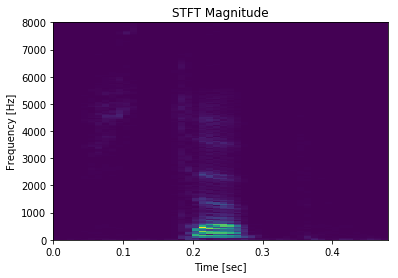

In [4]:
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [5]:
folder = "test3/"
files = ["enavant.wav", "enavant2.wav", "enavant3.wav", "adroite.wav", "adroite2.wav", "adroite3.wav", "agauche.wav", "agauche2.wav", "agauche3.wav", "stop.wav", "stop2.wav", "stop3.wav"]
file = "stop.wav"

In [6]:
def get_stft(folder, file, nperseg, noverlap):
    [fs, a] = read(folder + file)
    sig = np.array(a,dtype=float)
    f, t, Zxx = signal.stft(x = sig, fs=fs, noverlap=noverlap, nperseg=nperseg)
    fft_signal = {
        "frequencies": f,
        "times": t,
        "stft": Zxx
    }
    if "avant" in file:
        fft_signal["class"] = "avant"
    elif "droite" in file:
        fft_signal["class"] = "droite"
    elif "gauche" in file:
        fft_signal["class"] = "gauche"
    elif "stop" in file:
        fft_signal["class"] = "stop"
    return fft_signal

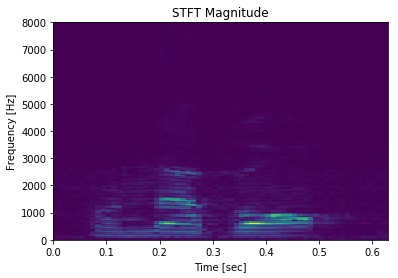

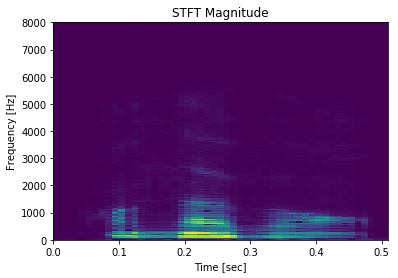

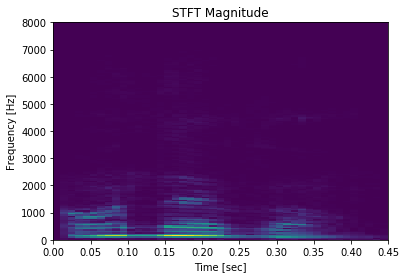

In [7]:
signals = []
for file_ in files:
    signal_ = get_stft(folder=folder, file=file_, nperseg=320, noverlap=160)
    signals.append(signal_)
    if signal_.get('class') == 'avant':
        plt.pcolormesh(signal_.get('times'), signal_.get('frequencies'), np.abs(signal_.get('stft')), vmin=0)
        plt.title('STFT Magnitude')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()

In [8]:
[fs, a] = read("test3/stop.wav")
signal_avant = np.array(a,dtype=float)

In [9]:
# Pre-Emphasis Filter
pre_emphasis = 0.97
emphasized_signal = np.append(signal_avant[0], signal_avant[1:] - pre_emphasis * signal_avant[:-1])

In [10]:
# FFT
NFFT = 512
nperseg = 320
windows = [signal.tukey(320), signal.nuttall(320), 'hamming', 'hann', signal.triang(320)]
window = 'hamming'
overlap = 160
f, t, Zxx = signal.stft(x = emphasized_signal, fs=fs, nperseg=nperseg, noverlap=overlap, nfft=NFFT, window=window)

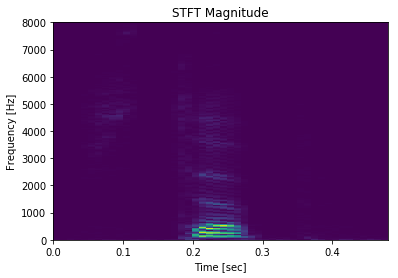

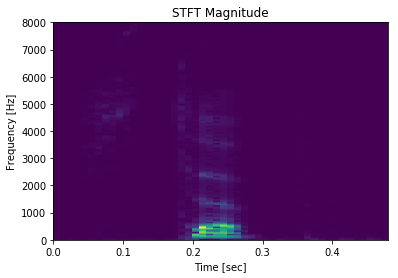

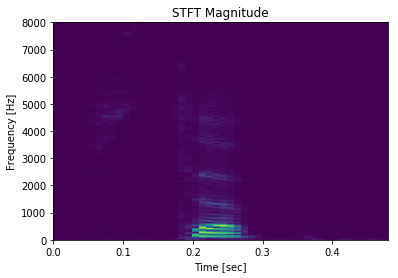

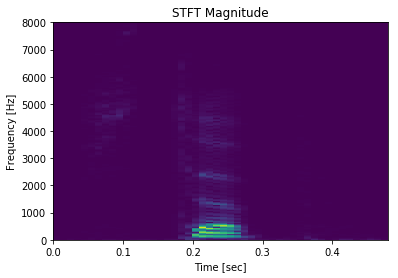

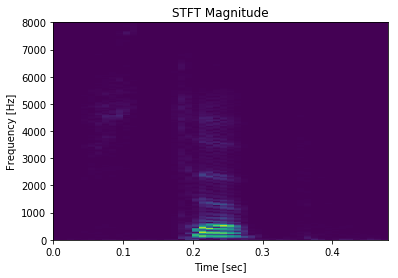

In [11]:
for window in windows:
    f, t, Zxx = signal.stft(x = signal_avant, fs=fs, nperseg=nperseg, noverlap=overlap, nfft=NFFT, window=window)
    plt.pcolormesh(t, f, np.abs(Zxx), vmin=0)
    plt.title('STFT Magnitude')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

In [12]:
# Filter Banks
nfilt = 40
low_freq_mel = 0
high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # Convert Hz to Mel
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = np.floor((NFFT + 1) * hz_points / fs)

fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = np.dot(np.transpose(Zxx), fbank.T)
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * np.log10(filter_banks)  # dB

In [13]:
# MFCC
num_ceps = 12
mfcc = fftpack.dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]

In [14]:
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
cep_lifter = 22
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift  #*

In [15]:
mfcc -= (np.mean(mfcc, axis=0) + 1e-8)

In [16]:
def apply_preemphasis_filter(data_signal):
    # Pre-Emphasis Filter
    pre_emphasis = 0.97
    emphasized_signal = np.append(data_signal[0], data_signal[1:] - pre_emphasis * data_signal[:-1])
    return emphasized_signal

In [17]:
def apply_stft(data_signal, fs, NFFT=512):
    # FFT
    nperseg = 320
    window = 'hamming'
    overlap = 160
    f, t, Zxx = signal.stft(x = data_signal, fs=fs, nperseg=nperseg, noverlap=overlap, nfft=NFFT, window=window)
    return f, t, Zxx

In [18]:
def apply_filter_banks(Zxx, fs, NFFT):
    # Filter Banks
    nfilt = 40
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((NFFT + 1) * hz_points / fs)

    fbank = np.zeros((nfilt, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    filter_banks = np.dot(Zxx.T, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB
    return filter_banks

In [19]:
def apply_mfcc(filter_banks):
    # MFCC
    num_ceps = 12
    mfcc = fftpack.dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)]
    (nframes, ncoeff) = mfcc.shape
    n = np.arange(ncoeff)
    cep_lifter = 22
    lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
    mfcc *= lift
    mfcc -= (np.mean(mfcc, axis=0) + 1e-8)
    return mfcc

In [20]:
def process_file(filename):
    [fs, a] = read(filename)
    data_signal = np.array(a,dtype=float)
    data_signal = apply_preemphasis_filter(data_signal)
    f, t, Zxx = apply_stft(data_signal, fs)
    filter_banks = apply_filter_banks(Zxx, fs, NFFT=512)
    mfcc = apply_mfcc(filter_banks)
    return mfcc

In [21]:
def altDTWDistance(s1, s2,w):
    DTW={}

    w = max(w, abs(len(s1)-len(s2)))

    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= np.sqrt(sum(np.abs((s1[i]-s2[j])**2)))
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return DTW[len(s1)-1, len(s2)-1]

In [22]:
def DTWDistance(s1, s2):
    DTW={}

    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= np.sqrt(sum(np.abs((s1[i]-s2[j]))**2))
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return DTW[len(s1)-1, len(s2)-1]

In [23]:
def diff_mfcc(s1, s2):
    diff = []
    for i in range(0, min(len(s1), len(s2))):
        current_diff = s1[i] - s2[i]
        diff.append(current_diff)
    plt.pcolormesh(np.real(diff))
    plt.show()

In [24]:
folder = "test3/"
files = []
files.append({
    "filename": "enavant.wav",
    "class": "forward",
})
files.append({
    "filename": "enavant2.wav",
    "class": "forward",
})
files.append({
    "filename": "enavant3.wav",
    "class": "forward",
})
files.append({
    "filename": "enavant_1_paul.wav",
    "class": "forward",
})
files.append({
    "filename": "enavant_2_paul.wav",
    "class": "forward",
})
files.append({
    "filename": "enavant_3_paul.wav",
    "class": "forward",
})
files.append({
    "filename": "enavant_1_remi.wav",
    "class": "forward",
})
files.append({
    "filename": "enavant_2_remi.wav",
    "class": "forward",
})
files.append({
    "filename": "enavant_3_remi.wav",
    "class": "forward",
})
files.append({
    "filename": "adroite.wav",
    "class": "right",
})
files.append({
    "filename": "adroite2.wav",
    "class": "right",
})
files.append({
    "filename": "adroite3.wav",
    "class": "right",
})
files.append({
    "filename": "adroite_1_paul.wav",
    "class": "right",
})
files.append({
    "filename": "adroite_2_paul.wav",
    "class": "right",
})
files.append({
    "filename": "adroite_3_paul.wav",
    "class": "right",
})
files.append({
    "filename": "adroite_1_remi.wav",
    "class": "right",
})
files.append({
    "filename": "adroite_2_remi.wav",
    "class": "right",
})
files.append({
    "filename": "adroite_3_remi.wav",
    "class": "right",
})
files.append({
    "filename": "agauche.wav",
    "class": "left",
})
files.append({
    "filename": "agauche2.wav",
    "class": "left",
})
files.append({
    "filename": "agauche3.wav",
    "class": "left",
})
files.append({
    "filename": "agauche_1_paul.wav",
    "class": "left",
})
files.append({
    "filename": "agauche_2_paul.wav",
    "class": "left",
})
files.append({
    "filename": "agauche_3_paul.wav",
    "class": "left",
})
files.append({
    "filename": "agauche_1_remi.wav",
    "class": "left",
})
files.append({
    "filename": "agauche_2_remi.wav",
    "class": "left",
})
files.append({
    "filename": "agauche_3_remi.wav",
    "class": "left",
})
files.append({
    "filename": "stop.wav",
    "class": "stop",
})
files.append({
    "filename": "stop2.wav",
    "class": "stop",
})
files.append({
    "filename": "stop3.wav",
    "class": "stop",
})
files.append({
    "filename": "stop_1_paul.wav",
    "class": "stop",
})
files.append({
    "filename": "stop_2_paul.wav",
    "class": "stop",
})
files.append({
    "filename": "stop_3_paul.wav",
    "class": "stop",
})
files.append({
    "filename": "stop_1_remi.wav",
    "class": "stop",
})
files.append({
    "filename": "stop_2_remi.wav",
    "class": "stop",
})
files.append({
    "filename": "stop_3_remi.wav",
    "class": "stop",
})

In [25]:
def get_classes(dtw_distance):
    dist1 = {'dist': float('inf')}
    dist2 = {'dist': float('inf')}
    for idx in range(len(dtw_distance)):
        dist = dtw_distance[idx]['dtw']
        if dist == 0:
            continue
        elif dist < dist1.get('dist'):
            dist2 = dist1
            dist1 = {'dist': dist, 'class': dtw_distance[idx]['class']}
        elif dist < dist2.get('dist'):
            dist2 = {'dist': dist, 'class': dtw_distance[idx]['class']}

    classes = [0, 0, 0, 0]
    if dist1.get('class') == 'forward':
        classes[0] = classes[0] + 1
    elif dist1.get('class') == 'right':
        classes[1] = classes[1] + 1
    elif dist1.get('class') == 'left':
        classes[2] = classes[2] + 1
    elif dist1.get('class') == 'stop':
        classes[3] = classes[3] + 1
    if dist2.get('class') == 'forward':
        classes[0] = classes[0] + 1
    elif dist2.get('class') == 'right':
        classes[1] = classes[1] + 1
    elif dist2.get('class') == 'left':
        classes[2] = classes[2] + 1
    elif dist2.get('class') == 'stop':
        classes[3] = classes[3] + 1
    return classes

def get_classes_1n(dtw_distance):
    dist1 = {'dist': 1000000000}
    for idx in range(len(dtw_distance)):
        dist = dtw_distance[idx]['dtw']
        if dist == 0:
            continue
        elif dist < dist1.get('dist'):
            dist1 = {'dist': dist, 'class': dtw_distance[idx]['class']}
    classes = [0, 0, 0, 0]
    if dist1.get('class') == 'forward':
        classes[0] = classes[0] + 1
    elif dist1.get('class') == 'right':
        classes[1] = classes[1] + 1
    elif dist1.get('class') == 'left':
        classes[2] = classes[2] + 1
    elif dist1.get('class') == 'stop':
        classes[3] = classes[3] + 1
    return classes

In [26]:
file = "enavant2.wav"
mfcc_stop = process_file(folder + file)
mfccs = []
dtw_distance = []
processed = []
for file_ in files:
    mfcc = process_file(folder + file_.get('filename'))
    mfccs.append(mfcc)
for mfcc in mfccs:
    dtw_distance.append(DTWDistance(mfcc_stop, mfcc))

In [27]:
dtw_distance

[37170.704498190891,
 0.0,
 29739.038979076926,
 94712.999903260803,
 83385.816298437101,
 107238.39777157499,
 100555.91389056246,
 104206.49450023325,
 101326.52223565585,
 59295.155054871328,
 50974.154297340334,
 35126.745964260706,
 87539.202188315074,
 98240.137965621107,
 154546.51980750711,
 118819.56384576253,
 93254.407444906072,
 100668.27916792956,
 42481.606586019298,
 40044.958559677136,
 39015.167750464549,
 93340.472199802694,
 94325.801127264,
 98821.009195661012,
 109893.80586777601,
 122002.83202700931,
 109362.1397197327,
 31587.266473137814,
 42079.893289826345,
 43985.926103688631,
 78344.93659289708,
 81197.779726606386,
 84468.620615631546,
 76763.247516179938,
 119242.2208088004,
 100832.93519173129]

In [28]:
for fileIdx in range(len(files)):
    filename = files[fileIdx].get('filename')
    mfcc = process_file(folder + filename)
    files[fileIdx]['mfcc'] = mfcc
for fileIdx1 in range(len(files)):
    file1 = files[fileIdx1]
    dtw_distance = []
    for fileIdx2 in range(len(files)):
        file2 = files[fileIdx2]
        dtw_distance.append({'class': file2.get('class'), 'dtw': altDTWDistance(file1.get('mfcc'), file2.get('mfcc'), 15)})
    print(file1.get('filename') + ':')
    print(get_classes_1n(dtw_distance))

enavant.wav:
[1, 0, 0, 0]
enavant2.wav:
[1, 0, 0, 0]
enavant3.wav:
[1, 0, 0, 0]
enavant_1_paul.wav:
[1, 0, 0, 0]
enavant_2_paul.wav:
[1, 0, 0, 0]
enavant_3_paul.wav:
[1, 0, 0, 0]
enavant_1_remi.wav:
[1, 0, 0, 0]
enavant_2_remi.wav:
[1, 0, 0, 0]
enavant_3_remi.wav:
[1, 0, 0, 0]


In [29]:
plt.pcolormesh(np.real(mfccs[10]))
plt.colorbar()

In [305]:
len(mfccs[2])